## Setup

In [33]:
import os
import glob
import sys
import shutil
import pickle
import random as rnd
from tqdm import tqdm

import numpy as np
from numpy import random as np_rnd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

import librosa

import torch
from torch import nn
from torch.nn import functional as F

from matplotlib import rc, rcParams
import matplotlib.font_manager as fm
rc('font', family=fm.FontProperties(fname='./font/NanumSquareR.ttf').get_name())
rcParams['axes.unicode_minus'] = False

In [34]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    # python random
    rnd.seed(seed)
    # numpy random
    np_rnd.seed(seed)
    # tf random
    try:
        tf_rnd.set_seed(seed)
    except:
        pass
    # RAPIDS random
    try:
        cupy.random.seed(seed)
    except:
        pass
    # pytorch random
    try:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
    except:
        pass

def pickleIO(obj, src, op="w"):
    if op == "w":
        with open(src, op + "b") as f:
            pickle.dump(obj, f)
    elif op == "r":
        with open(src, op + "b") as f:
            tmp = pickle.load(f)
        return tmp
    else:
        print("unknown operation")
        return obj
    
def findIdx(data_x, col_names):
    return [int(i) for i, j in enumerate(data_x) if j in col_names]

def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory. ' + directory)
        
def week_of_month(dt):
    """ 
        Returns the week of the month for the specified date.
    """
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + (1 + first_day.weekday()) % 7
    return int(np.ceil(adjusted_dom/7.0))

def get_season(dt):
    dt = int(dt)
    if dt in [3, 4, 5]:
        return "봄"
    elif dt in [6, 7, 8]:
        return "여름"
    elif dt in [9, 10, 11]:
        return "가을"
    else:
        return "겨울"

In [35]:
class CFG:
    debug = True
    data_path = ".\\data\\"
    
    n_mfcc = 32
    n_chroma = 16

## Loading Data

In [36]:
df = pd.read_csv("./data/pig_perunit_rawdata_prep.csv")

In [37]:
df

,지역,규모,농장,개체번호,산차,교배일,임신사고일,분만일,총산,실산,생시총체,이유일,이유두수
0,경기도,100~200,2615,2,0,2014-10-30,61.0,NaN,NaN,NaN,NaN,NaN,NaN
1,경기도,100~200,2615,2,0,2015-01-23,NaN,2015-05-19,14.0,13.0,NaN,2015-06-11,13.0
2,경기도,100~200,2615,2,1,2015-06-16,NaN,2015-10-11,14.0,14.0,NaN,2015-10-29,9.0
3,경기도,100~200,2615,2,2,2015-11-03,NaN,2016-02-27,6.0,6.0,NaN,2016-03-17,6.0
4,경기도,100~200,2615,2,3,2016-03-21,NaN,2016-07-15,11.0,10.0,NaN,2016-07-19,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
156024,NaN,100~200,23203,119,9,2024-07-31,NaN,2024-11-23,6.0,6.0,NaN,2024-12-22,11.0
156025,NaN,100~200,23203,120,9,2024-08-01,NaN,2024-11-24,12.0,7.0,NaN,2024-12-22,11.0
156026,NaN,100~200,23203,121,5,2022-07-25,NaN,2022-11-17,15.0,14.0,NaN,2022-12-22,11.0
156027,NaN,100~200,23203,122,8,2023-07-24,NaN,2023-11-16,26.0,19.0,NaN,2023-12-15,11.0


In [38]:
df.isna().sum()

지역        52704
규모            0
농장            0
개체번호          0
산차            0
교배일           0
임신사고일    123618
분만일       39902
총산        39902
실산        39902
생시총체     151670
이유일       45108
이유두수      45108
dtype: int64

In [39]:
df.nunique()

지역          7
규모          7
농장         87
개체번호     1740
산차         19
교배일      6307
임신사고일     330
분만일      6445
총산         33
실산         29
생시총체        7
이유일      3683
이유두수       28
dtype: int64

In [40]:
# drop columns, rows
df = df.drop(["생시총체"], axis=1)
df = df[~df["이유두수"].isna()].reset_index(drop=True)
df.shape

(110921, 12)

In [41]:
df.isna().sum()

지역        35753
규모            0
농장            0
개체번호          0
산차            0
교배일           0
임신사고일    101500
분만일           0
총산            0
실산            0
이유일           0
이유두수          0
dtype: int64

In [42]:
# imputation
df["지역"] = df["지역"].fillna("unknown")
# 임신사고일이 nan이면 정상 분만을 했다는 의미 숫자로 -1로 대치
df["임신사고일"] = df["임신사고일"].fillna(-1)

In [43]:
df.isna().sum()

지역       0
규모       0
농장       0
개체번호     0
산차       0
교배일      0
임신사고일    0
분만일      0
총산       0
실산       0
이유일      0
이유두수     0
dtype: int64

In [44]:
df

,지역,규모,농장,개체번호,산차,교배일,임신사고일,분만일,총산,실산,이유일,이유두수
0,경기도,100~200,2615,2,0,2015-01-23,-1.0,2015-05-19,14.0,13.0,2015-06-11,13.0
1,경기도,100~200,2615,2,1,2015-06-16,-1.0,2015-10-11,14.0,14.0,2015-10-29,9.0
2,경기도,100~200,2615,2,2,2015-11-03,-1.0,2016-02-27,6.0,6.0,2016-03-17,6.0
3,경기도,100~200,2615,2,3,2016-03-21,-1.0,2016-07-15,11.0,10.0,2016-07-19,0.0
4,경기도,100~200,2615,3,0,2015-01-13,-1.0,2015-05-07,14.0,14.0,2015-06-11,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...
110916,unknown,100~200,23203,119,9,2024-07-31,-1.0,2024-11-23,6.0,6.0,2024-12-22,11.0
110917,unknown,100~200,23203,120,9,2024-08-01,-1.0,2024-11-24,12.0,7.0,2024-12-22,11.0
110918,unknown,100~200,23203,121,5,2022-07-25,-1.0,2022-11-17,15.0,14.0,2022-12-22,11.0
110919,unknown,100~200,23203,122,8,2023-07-24,-1.0,2023-11-16,26.0,19.0,2023-12-15,11.0


In [45]:
df[df["임신사고일"] != -1]

,지역,규모,농장,개체번호,산차,교배일,임신사고일,분만일,총산,실산,이유일,이유두수
12581,제주특별자치도,300~400,20199,328,1,2018-08-08,43.0,2019-02-19,9.0,9.0,2019-03-15,9.0
12721,제주특별자치도,300~400,20199,359,2,2019-08-18,68.0,2019-12-12,11.0,11.0,2020-01-11,9.0
12847,충청남도,400~500,20200,1,0,2016-02-17,25.0,2016-06-12,13.0,12.0,2016-07-07,11.0
12848,충청남도,400~500,20200,1,1,2016-07-11,25.0,2016-11-03,16.0,15.0,2016-12-01,13.0
12849,충청남도,400~500,20200,1,2,2017-05-16,25.0,2017-09-08,10.0,8.0,2017-10-05,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
84915,unknown,200~300,21297,323,0,2020-01-14,112.0,2020-05-08,13.0,13.0,2020-05-28,10.0
84921,unknown,200~300,21297,329,0,2020-04-17,60.0,2020-08-09,14.0,14.0,2020-08-27,13.0
84935,unknown,200~300,21297,351,0,2020-05-01,88.0,2020-08-24,20.0,20.0,2020-09-17,13.0
84938,unknown,200~300,21297,352,1,2020-07-07,77.0,2020-10-28,14.0,9.0,2020-11-19,11.0


In [46]:
df["교배일"] = pd.to_datetime(df["교배일"])
df["분만일"] = pd.to_datetime(df["분만일"])
df["이유일"] = pd.to_datetime(df["이유일"])

In [47]:
df = df[df["이유일"] < pd.to_datetime("20230315")].reset_index(drop=True)
df = df[df["교배일"] >= pd.to_datetime("20150101")].reset_index(drop=True)

In [48]:
df.head()

,지역,규모,농장,개체번호,산차,교배일,임신사고일,분만일,총산,실산,이유일,이유두수
0,경기도,100~200,2615,2,0,2015-01-23,-1.0,2015-05-19,14.0,13.0,2015-06-11,13.0
1,경기도,100~200,2615,2,1,2015-06-16,-1.0,2015-10-11,14.0,14.0,2015-10-29,9.0
2,경기도,100~200,2615,2,2,2015-11-03,-1.0,2016-02-27,6.0,6.0,2016-03-17,6.0
3,경기도,100~200,2615,2,3,2016-03-21,-1.0,2016-07-15,11.0,10.0,2016-07-19,0.0
4,경기도,100~200,2615,3,0,2015-01-13,-1.0,2015-05-07,14.0,14.0,2015-06-11,13.0


## Add climate feature

In [49]:
# Temperature
seoul_temp = pd.read_csv("./data/seoul_temperature_high.csv", encoding="cp949").dropna()
seoul_temp = seoul_temp[["일시", "최고기온(℃)"]]
seoul_temp.columns = ["timestamp", "temp"]
seoul_temp["timestamp"] = pd.to_datetime(seoul_temp["timestamp"])
seoul_temp = seoul_temp.set_index("timestamp")["temp"]

In [50]:
seoul_temp

timestamp
2015-01-01    -4.3
2015-01-02    -1.9
2015-01-03     3.1
2015-01-04     8.5
2015-01-05     7.9
              ... 
2023-03-10    22.2
2023-03-11    22.8
2023-03-12    12.6
2023-03-13     7.6
2023-03-14    15.4
Name: temp, Length: 2993, dtype: float64

In [51]:
# Humidity
busan_hum = pd.read_csv("./data/busan_humidity_mean.csv", encoding="cp949").dropna()
busan_hum = busan_hum[["일시", "평균습도(%rh)"]]
busan_hum.columns = ["timestamp", "hum"]
busan_hum["timestamp"] = pd.to_datetime(busan_hum["timestamp"])
busan_hum = busan_hum.set_index("timestamp")["hum"]

In [52]:
busan_hum

timestamp
2015-01-01    35.4
2015-01-02    41.3
2015-01-03    32.0
2015-01-04    53.8
2015-01-05    67.4
              ... 
2023-03-10    78.0
2023-03-11    85.1
2023-03-12    79.8
2023-03-13    40.1
2023-03-14    56.4
Name: hum, Length: 2995, dtype: float64

## EDA on 이유두수

In [53]:
df_eda = df.copy()

In [54]:
# remove outlier for target
df_eda = df_eda[(df_eda["이유두수"] < 30) & (df_eda["이유두수"] >= 0)].reset_index(drop=True)

In [55]:
df_eda["temp_교배일"] = df_eda["교배일"].map(seoul_temp).values
df_eda["hum_교배일"] = df_eda["교배일"].map(busan_hum).values

df_eda["temp_분만일"] = df_eda["분만일"].map(seoul_temp).values
df_eda["hum_분만일"] = df_eda["분만일"].map(busan_hum).values

df_eda["temp_이유일"] = df_eda["이유일"].map(seoul_temp).values
df_eda["hum_이유일"] = df_eda["이유일"].map(busan_hum).values

In [56]:
df_eda["month_교배일"] = df_eda["교배일"].dt.month.values
df_eda["season_교배일"] = df_eda["month_교배일"].apply(get_season)

df_eda["month_분만일"] = df_eda["분만일"].dt.month.values
df_eda["season_분만일"] = df_eda["month_분만일"].apply(get_season)

df_eda["month_이유일"] = df_eda["이유일"].dt.month.values
df_eda["season_이유일"] = df_eda["month_이유일"].apply(get_season)

In [57]:
# 교배일이 2015 이전인 샘플은 삭제 (온도와 습도 데이터 merge 시 nan 값이 됨)
df_eda = df_eda.dropna().reset_index(drop=True)

In [58]:
df_eda.iloc[:, :15]

,지역,규모,농장,개체번호,산차,교배일,임신사고일,분만일,총산,실산,이유일,이유두수,temp_교배일,hum_교배일,temp_분만일
0,경기도,100~200,2615,2,0,2015-01-23,-1.0,2015-05-19,14.0,13.0,2015-06-11,13.0,4.9,58.1,16.2
1,경기도,100~200,2615,2,1,2015-06-16,-1.0,2015-10-11,14.0,14.0,2015-10-29,9.0,30.9,89.4,14.4
2,경기도,100~200,2615,2,2,2015-11-03,-1.0,2016-02-27,6.0,6.0,2016-03-17,6.0,18.7,57.0,8.1
3,경기도,100~200,2615,2,3,2016-03-21,-1.0,2016-07-15,11.0,10.0,2016-07-19,0.0,16.1,59.6,29.2
4,경기도,100~200,2615,3,0,2015-01-13,-1.0,2015-05-07,14.0,14.0,2015-06-11,13.0,5.8,58.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102770,unknown,100~200,23203,112,0,2022-07-18,-1.0,2022-11-10,11.0,11.0,2022-12-15,11.0,30.1,95.8,19.1
102771,unknown,100~200,23203,114,5,2022-07-26,-1.0,2022-11-18,16.0,15.0,2022-12-22,11.0,33.1,83.4,18.1
102772,unknown,100~200,23203,115,0,2022-07-27,-1.0,2022-11-18,11.0,11.0,2022-12-22,11.0,33.4,77.3,18.1
102773,unknown,100~200,23203,116,0,2022-07-18,-1.0,2022-11-10,17.0,16.0,2022-12-15,11.0,30.1,95.8,19.1


In [59]:
df_eda.isna().sum().sum()

0

### Correlation heatmap on numerical feature

In [60]:
df_eda.columns

Index(['지역', '규모', '농장', '개체번호', '산차', '교배일', '임신사고일', '분만일', '총산', '실산',
       '이유일', '이유두수', 'temp_교배일', 'hum_교배일', 'temp_분만일', 'hum_분만일', 'temp_이유일',
       'hum_이유일', 'month_교배일', 'season_교배일', 'month_분만일', 'season_분만일',
       'month_이유일', 'season_이유일'],
      dtype='object')

In [61]:
feature_info = {
    "cat_vars": ["지역", "규모", "농장", "개체번호", 'month_교배일', 'season_교배일', 'month_분만일', 'season_분만일', 'month_이유일', 'season_이유일'],
    "date_vars": ["교배일", "분만일", "이유일"],
    "num_vars": [],
}
feature_info["num_vars"] = diff(df_eda.columns, feature_info["cat_vars"] + feature_info["date_vars"])
feature_info

{'cat_vars': ['지역',
  '규모',
  '농장',
  '개체번호',
  'month_교배일',
  'season_교배일',
  'month_분만일',
  'season_분만일',
  'month_이유일',
  'season_이유일'],
 'date_vars': ['교배일', '분만일', '이유일'],
 'num_vars': ['산차',
  '임신사고일',
  '총산',
  '실산',
  '이유두수',
  'temp_교배일',
  'hum_교배일',
  'temp_분만일',
  'hum_분만일',
  'temp_이유일',
  'hum_이유일']}

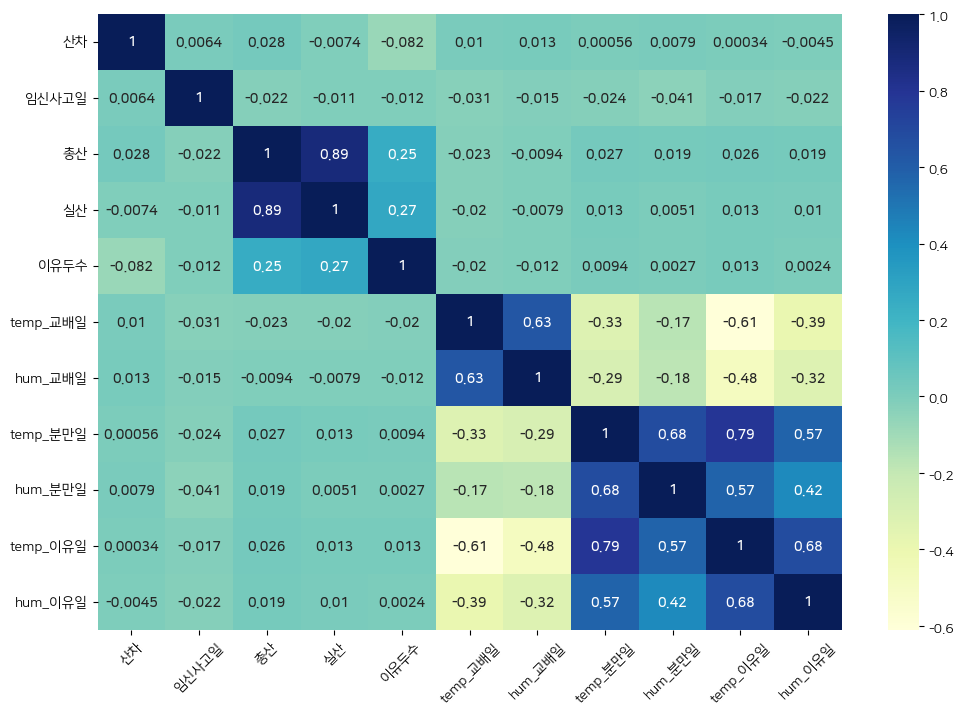

In [62]:
fig = plt.figure(figsize=(12, 8))
sns.heatmap(df_eda[feature_info["num_vars"]].corr(), cmap="YlGnBu", annot=True, annot_kws={"fontweight": "bold"})
plt.xticks(rotation=45)
plt.show()

In [63]:
lm_x = pd.DataFrame(StandardScaler().fit_transform(df_eda[feature_info["num_vars"]].drop("이유두수", axis=1)), columns=df_eda[feature_info["num_vars"]].drop("이유두수", axis=1).columns)
lm_y = df_eda["이유두수"].copy().values
model = sm.OLS(lm_y, lm_x)
result = model.fit()
lm_x.head()

,산차,임신사고일,총산,실산,temp_교배일,hum_교배일,temp_분만일,hum_분만일,temp_이유일,hum_이유일
0,-1.054502,-0.3121,0.292665,0.360572,-1.366205,-0.331438,-0.242508,0.891427,1.145841,1.496116
1,-0.631384,-0.3121,0.292665,0.654994,1.158864,1.367052,-0.416309,-0.535447,-0.338294,-0.440704
2,-0.208267,-0.3121,-1.852995,-1.700385,-0.025976,-0.391130,-1.024614,-0.557315,-0.338294,-0.307680
3,0.214850,-0.3121,-0.511957,-0.522695,-0.278483,-0.250041,1.012725,0.328331,1.356492,0.846962
4,-1.054502,-0.3121,0.292665,0.654994,-1.278799,-0.336865,0.510632,-0.847063,1.145841,1.496116


In [64]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              31.82
Date:                Fri, 17 Mar 2023   Prob (F-statistic):                    2.78e-62
Time:                        15:07:58   Log-Likelihood:                     -3.9052e+05
No. Observations:              102775   AIC:                                  7.811e+05
Df Residuals:                  102765   BIC:                                  7.812e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
산차            -0.1689      0.034     -4.990      0.000      -0.235      -0.103
임신사고일         -0.0185      0.034     -0.548      0.584      -0.085       0.048
총산             0.0637      0.073      0.871      0.384      -0.080       0.207
실산             0.5176      0.073      7.079      0.000       0.374       0.661
temp_교배일      -0.0236      0.051     -0.460      0.645      -0.124       0.077
hum_교배일       -0.0027      0.044     -0.062      0.950      -0.089       0.084
temp_분만일       0.0058      0.064      0.090      0.928      -0.119       0.131
hum_분만일       -0.0062      0.047     -0.132      0.895      -0.098       0.085
temp_이유일       0.0206      0.077      0.269      0.788      -0.129       0.171
hum_이유일       -0.0273      0.046     -0.591      0.555      -0.118       0.063
==============================================================================
Omnibus:                    44170.466   Durbin-Watson:                   0.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           692965.318
Skew:                          -1.657   Prob(JB):                         0.00
Kurtosis:                      15.281   Cond. No.                         5.53
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Note: Summarization

* There isn't any variable which shows high correlation with others

### Box plot on categorical feature

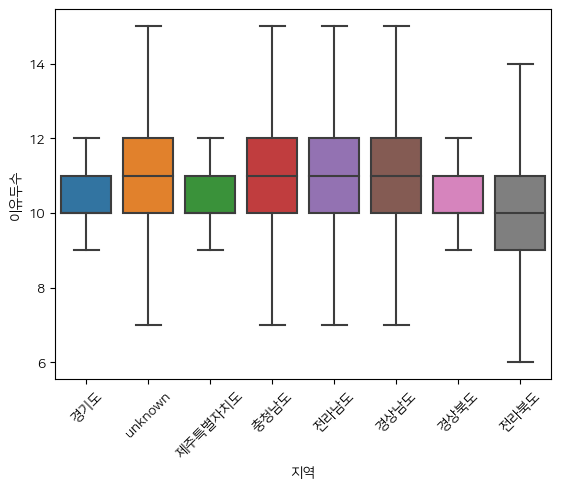

ANOVA : Groups are different -> 0.0


지역,unknown,경기도,경상남도,경상북도,전라남도,전라북도,제주특별자치도,충청남도
이유두수,10.926203,10.218155,10.775912,10.508728,10.948655,9.855,10.250487,10.543819


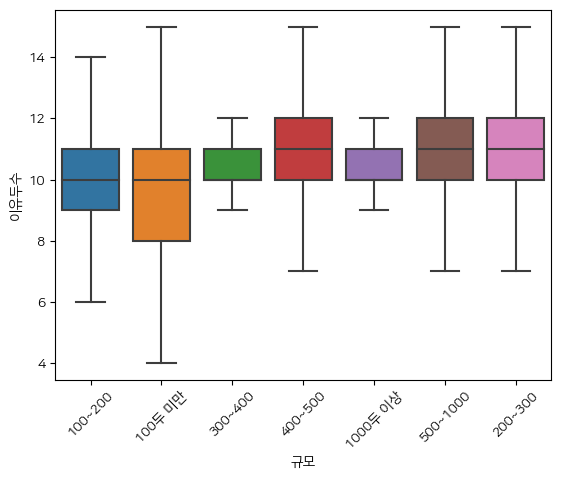

ANOVA : Groups are different -> 0.0


규모,1000두 이상,100~200,100두 미만,200~300,300~400,400~500,500~1000
이유두수,10.437462,9.882353,9.442804,10.699946,10.195407,11.148985,10.91099


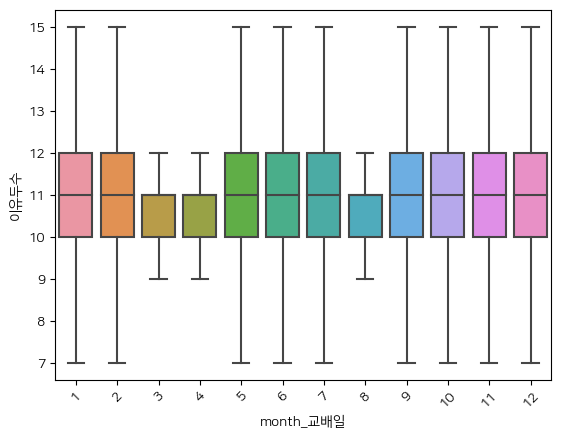

ANOVA : Groups are different -> 0.0


month_교배일,1,2,3,4,5,6,7,8,9,10,11,12
이유두수,10.689413,10.718203,10.49836,10.503632,10.667966,10.744557,10.601504,10.492062,10.63565,10.482879,10.681943,10.798068


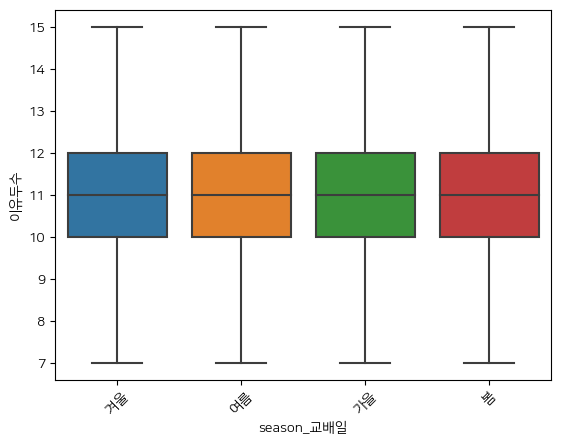

ANOVA : Groups are different -> 0.0


season_교배일,봄,여름,가을,겨울
이유두수,10.562883,10.619143,10.600838,10.735276


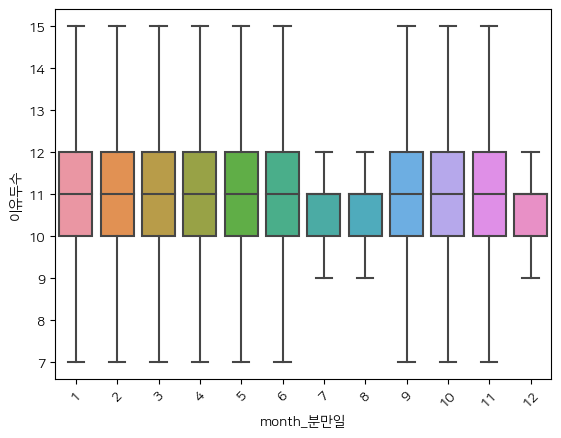

ANOVA : Groups are different -> 0.0


month_분만일,1,2,3,4,5,6,7,8,9,10,11,12
이유두수,10.603626,10.498245,10.704135,10.806178,10.694943,10.692701,10.453253,10.548741,10.698547,10.713524,10.576055,10.52209


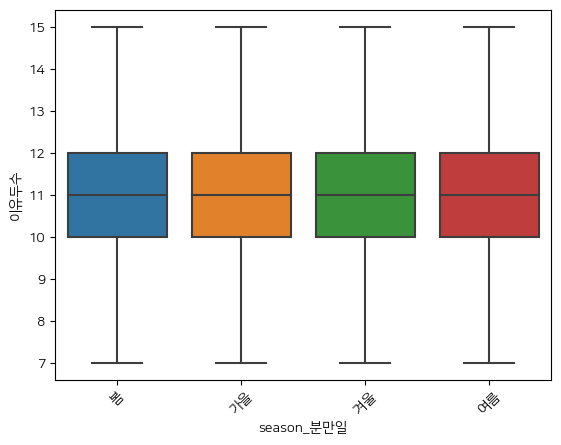

ANOVA : Groups are different -> 0.0


season_분만일,봄,여름,가을,겨울
이유두수,10.734233,10.559948,10.667946,10.543514


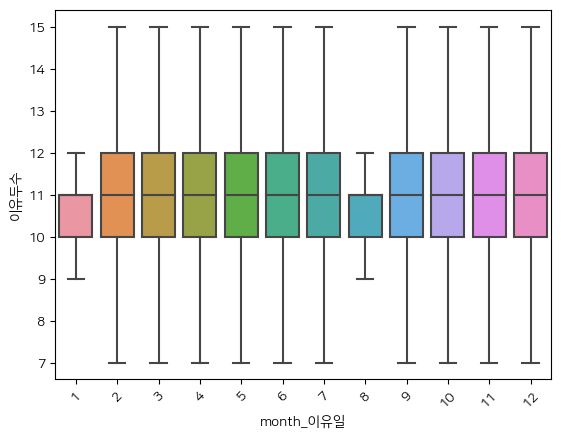

ANOVA : Groups are different -> 0.0


month_이유일,1,2,3,4,5,6,7,8,9,10,11,12
이유두수,10.55354,10.529978,10.591995,10.724514,10.755892,10.670977,10.676267,10.421605,10.614834,10.689284,10.688875,10.578606


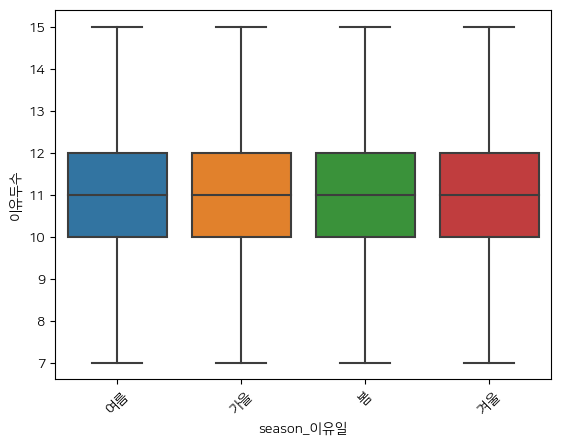

ANOVA : Groups are different -> 0.0


season_이유일,봄,여름,가을,겨울
이유두수,10.693519,10.586677,10.663362,10.555529


In [65]:
for i in feature_info["cat_vars"]:
    if i in ["농장", "개체번호"]:
        continue
    _, pvalue = f_oneway(*[df_eda.loc[df_eda[i] == j, "이유두수"].values for j in df_eda[i].unique() if j != "unknown"])
    if pvalue < 0.05:
        sns.boxplot(x=df_eda[i], y=df_eda["이유두수"], showfliers=False)
        plt.xticks(rotation=45)
        plt.show()
        print(f"ANOVA : Groups are different -> {np.round(pvalue, 5)}")
        if "season" in i:
            display(df_eda.groupby(i)["이유두수"].mean().to_frame().T[["봄", "여름", "가을", "겨울"]])
        else:
            display(df_eda.groupby(i)["이유두수"].mean().to_frame().T)

### Note: Summarization

* 겨울에 교배를 하고 봄에 분만을 하는 개체 그룹의 이유두수 평균이 비교적 높다.
* 상관관계 히트맵에서는 온도와 습도의 상관관계 수치가 낮은 것으로 파악이 되어 계절영향이 크지는 않은 것으로 보인다.